#### 0. Utility methods

In [537]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_missing_value_percentage(data):
    temp = (data.isnull().sum()/data.shape[0])*100
    temp = temp[temp > 0]
    return temp

def draw_missing_value_percentage(data):
    temp = get_missing_value_percentage(data)
    plt.figure(figsize=(20,5))
    plt.xticks(rotation = 90)
    sns.barplot(temp)
    plt.show()

def set_na_to_median(data, column_name):
    condition = data[column_name].isna()
    median = data[column_name].median()
    data.loc[condition, column_name] = median

def set_na_to_value(data, column_name, value):
    condition = data[column_name].isna()
    data.loc[condition, column_name] = value

# 1. Problem Statement

- in the telecom industry, customers churn(leave the service by a provider)
- the telecom industry has collected data for 3 months, there were churns in these 3 months.
- as a data scientist, we need to identify the patterns and reasons of these churns using ML modelling techniques
- the success of the model depends on the accuracy of predictions on the test(unseen) data. If we are able to predict the churn correctly for a reasonable number of customers in the unseen data, we can say which features impact the churn and what action items can be taken to reduce the churn(retain the customers)

# 2. First look at the data 

## 2.1 Loading and looking at the dataset

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dictionary = pd.read_csv('data_dictionary.csv')
inp0 = pd.read_csv('train.csv')

## 2.2 Shape

In [399]:
inp0.shape

(69999, 172)

## 2.3 Column comprehension

In [400]:
data = inp0
# a lot of columns have _6, _7, _8 in them, let's drop the suffix to understand what columns exist
columns = data.columns
columns = columns.str.replace('_6', '')
columns = columns.str.replace('_7', '')
columns = columns.str.replace('_8', '')
print(columns.unique().shape)
print(columns.unique().sort_values())

(64,)
Index(['aon', 'arpu', 'arpu_2g', 'arpu_3g', 'aug_vbc_3g', 'av_rech_amt_data',
       'churn_probability', 'circle_id', 'count_rech_2g', 'count_rech_3g',
       'date_of_last_rech', 'date_of_last_rech_data', 'fb_user', 'ic_others',
       'id', 'isd_ic_mou', 'isd_og_mou', 'jul_vbc_3g', 'jun_vbc_3g',
       'last_date_of_month', 'last_day_rch_amt', 'loc_ic_mou',
       'loc_ic_t2f_mou', 'loc_ic_t2m_mou', 'loc_ic_t2o_mou', 'loc_ic_t2t_mou',
       'loc_og_mou', 'loc_og_t2c_mou', 'loc_og_t2f_mou', 'loc_og_t2m_mou',
       'loc_og_t2o_mou', 'loc_og_t2t_mou', 'max_rech_amt', 'max_rech_data',
       'monthly_2g', 'monthly_3g', 'night_pck_user', 'offnet_mou', 'og_others',
       'onnet_mou', 'roam_ic_mou', 'roam_og_mou', 'sachet_2g', 'sachet_3g',
       'spl_ic_mou', 'spl_og_mou', 'std_ic_mou', 'std_ic_t2f_mou',
       'std_ic_t2m_mou', 'std_ic_t2o_mou', 'std_ic_t2t_mou', 'std_og_mou',
       'std_og_t2c_mou', 'std_og_t2f_mou', 'std_og_t2m_mou', 'std_og_t2o_mou',
       'std_og_t2t_mou',

In [530]:
data = inp0
# direction of calls => ic, og
# type of calls => loc, std, isd, roam, spl, others
# call between operators => within network(t2t, t2f, t2c), outside network(t2m, t2o)
# mobile network band => 2g, 3g
# loyalty related => aon
# data usage related => vol_2g, vol_3g
# calling usage related => mou => about 90 columns related to mou
# money related => arpu, rech_amt
# count related => rech_num, total_rech_data, count_rech_2g, count_rech_3g
# other parameters => fb_user
columns_to_select_1 = data.columns.str.contains('vbc')
columns_to_select_2 = data.columns.str.contains('')

data.loc[:, columns_to_select_1 & columns_to_select_2].head()

,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [402]:
data_dictionary

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


## 2.3 Observations

- there are about 172 columns, about 70k rows
- the columns can be understood as follows
    - direction of calls => ic, og
    - type of calls => loc, std, isd, roam, spl, others
    - call between operators => within network(t2t, t2f, t2c), outside network(t2m, t2o)
    - mobile network band => 2g, 3g
    - loyalty related => aon
    - data usage related => vol_2g, vol_3g
    - calling usage related => mou => about 90 columns related to mou
    - money related => arpu, rech_amt
    - type of recharges => nightly, sachet, monthly
    - count related => rech_num, total_rech_data, count_rech_2g, count_rech_3g
    - other parameters => fb_user

# 3. Preparation, Pre-Processing

## 3.1 Removal of columns with single value (one value and NaNs)

In [403]:
data = inp0
temp = data.nunique() # gives unique count of all the columns
unique_condition_1 = temp == 1 # which columns have just 1 unique value
temp = temp[unique_condition_1]

# verify single value
print(temp)
data[temp.index]

circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_ic_t2o_mou_6        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
dtype: int64


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69996,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0
69997,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0


In [504]:
data = inp0
data['circle_id'].unique() # contains on 109, can be removed
data = data.drop(columns=['circle_id'])

data['loc_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_og_t2o_mou'])

data['std_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2o_mou'])

data['loc_ic_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_ic_t2o_mou'])

data['std_og_t2c_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_6'])

data['std_og_t2c_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_7'])

data['std_og_t2c_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_8'])

data['std_ic_t2o_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_6'])

data['std_ic_t2o_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_7'])

data['std_ic_t2o_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_8'])

data['last_date_of_month_6'].value_counts() # all of them have same value
data = data.drop(columns=['last_date_of_month_6'])

data['last_date_of_month_7'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_7'])

data['last_date_of_month_8'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_8'])

inp1 = data


### 3.1.1 Observation
- about 13 columns are dropped

## 3.2 Change data type of datetime columns from object to datetime

In [505]:
data = inp1
data.select_dtypes(include=['object'])
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'])
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'])
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
data['date_of_last_rech_data_6'] = pd.to_datetime(data['date_of_last_rech_data_6'])
data['date_of_last_rech_data_7'] = pd.to_datetime(data['date_of_last_rech_data_7'])
data['date_of_last_rech_data_8'] = pd.to_datetime(data['date_of_last_rech_data_8'])

inp2 = data # the changes above are by reference, but just to be sure that in case we make a copy, inp1 is still updated


## 3.3 Missing value treatment

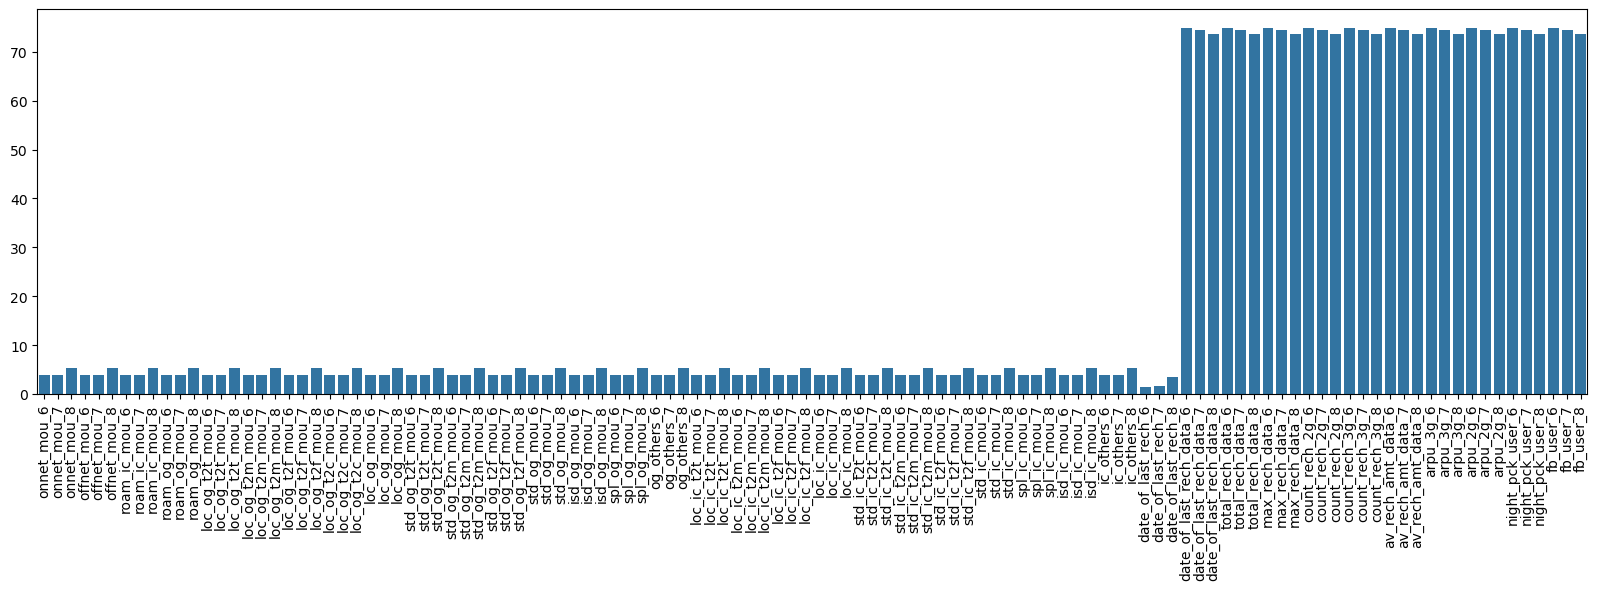

In [506]:
draw_missing_value_percentage(inp2)

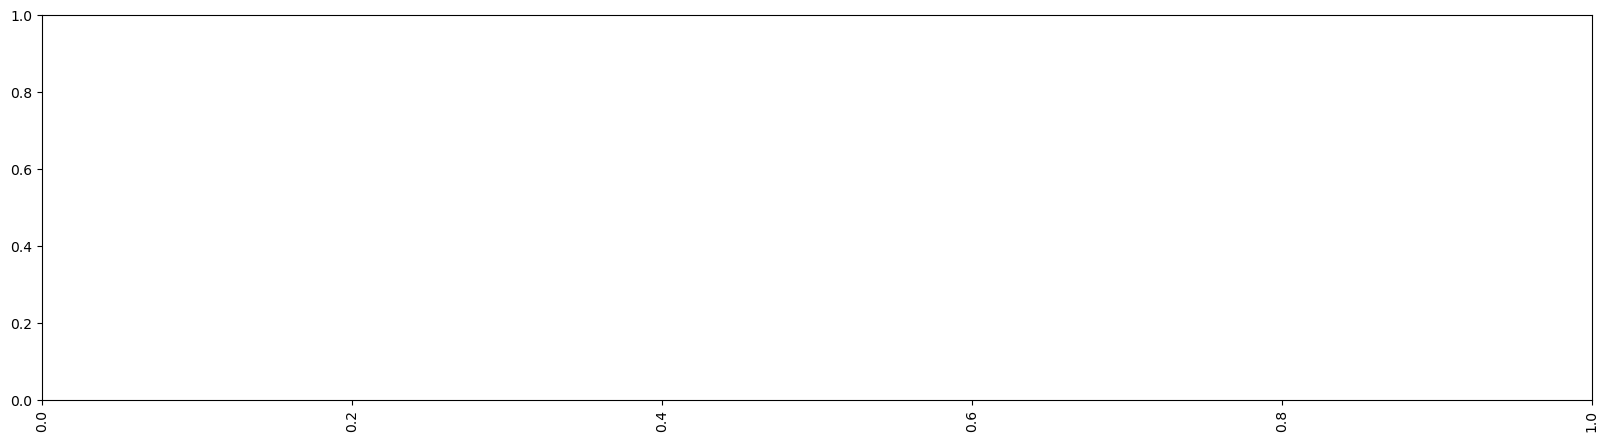

In [ ]:
# missing value imputation
data = inp2

# treat all mou columns to set na values to median
temp = get_missing_value_percentage(inp1)
mou_columns_with_na = temp.index[temp.index.str.contains('mou')]
[set_na_to_median(data, column) for column in mou_columns_with_na]

# treat all og_others, ic_others to set na values to median
[set_na_to_median(data, column) for column in ['og_others_6', 'og_others_7', 'og_others_8','ic_others_6', 'ic_others_7', 'ic_others_8']]

# treat all date_of_last_rech to set na values to median
[set_na_to_median(data, column) for column in ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']]

# set date_of_last_rech_data same as date_of_last_rech
condition = data['date_of_last_rech_data_6'].isna()
data.loc[condition, 'date_of_last_rech_data_6'] = data.loc[condition, 'date_of_last_rech_6']

condition = data['date_of_last_rech_data_7'].isna()
data.loc[condition, 'date_of_last_rech_data_7'] = data.loc[condition, 'date_of_last_rech_7']

condition = data['date_of_last_rech_data_8'].isna()
data.loc[condition, 'date_of_last_rech_data_8'] = data.loc[condition, 'date_of_last_rech_8']

# treat all arpu_2g/3g to set na values to median
[set_na_to_median(data, column) for column in ['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8']]

# treat all counts of recharges to set na values to 0
[set_na_to_value(data, column, 0) for column in ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']]

# total_rech_data is a sum of count_rech_2g and count_rech_3g, replacing the value will correct the data and impute missing values
data['total_rech_data_6'] = data['count_rech_2g_6'] + data['count_rech_3g_6']
data['total_rech_data_7'] = data['count_rech_2g_7'] + data['count_rech_3g_7']
data['total_rech_data_8'] = data['count_rech_2g_8'] + data['count_rech_3g_8']

# if total_rech_data is 0 (no recharge was done), max_rech_data and av_rech_amt_data is also 0
condition = data['total_rech_data_6'] == 0
data.loc[condition, 'max_rech_data_6'] = 0
data.loc[condition, 'av_rech_amt_data_6'] = 0

condition = data['total_rech_data_7'] == 0
data.loc[condition, 'max_rech_data_7'] = 0
data.loc[condition, 'av_rech_amt_data_7'] = 0

condition = data['total_rech_data_8'] == 0
data.loc[condition, 'max_rech_data_8'] = 0
data.loc[condition, 'av_rech_amt_data_8'] = 0

# assuming fb_user, night_pck_user to be 0 if information isn't available and mode is NaN
[set_na_to_value(data, column, 0) for column in ['fb_user_6', 'fb_user_7', 'fb_user_8','night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']]

draw_missing_value_percentage(data)
inp3 = data

### 3.3.1 Observation
- we have done some logical missing value imputations, we should validate the data with some sanity checks

## 3.4 Removal of empty rows

% rows missing greater than 1% of data = 0%
(0, 159)


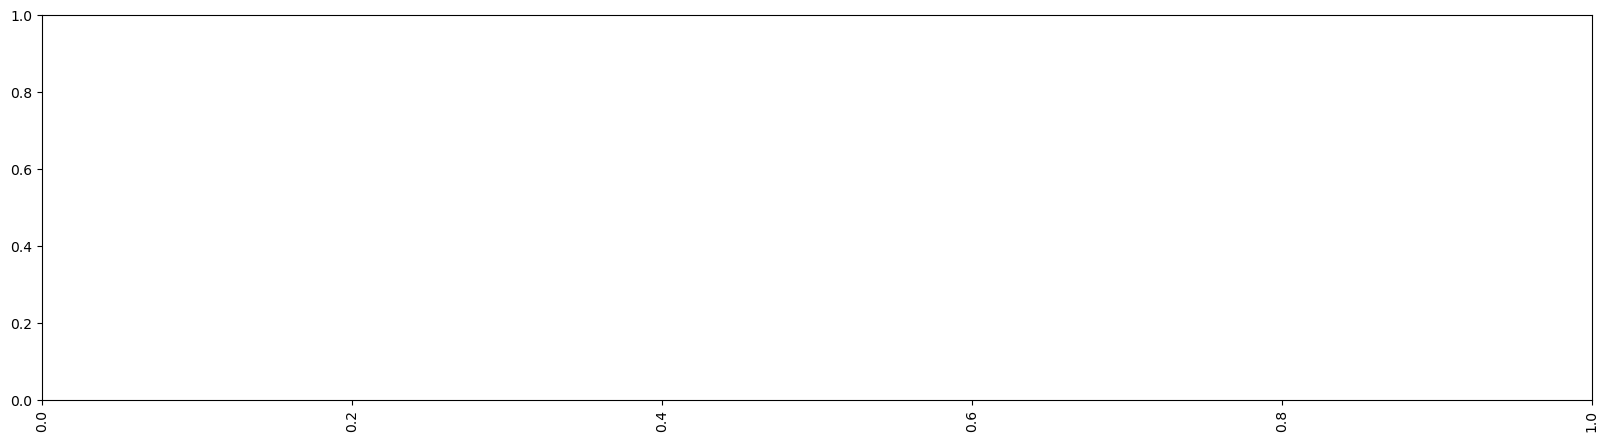

In [527]:
data = inp3
threshold = 1
temp = data.isnull().mean(axis=1)*100 > threshold
print(f'% rows missing greater than {threshold}% of data = {round(data[temp].shape[0]*100/data.shape[0])}%')
print(data[temp].shape)
draw_missing_value_percentage(data[~temp])

### 3.4.1 Observation
- we don't need to remove rows as there is no missing value now.

## 3.5 Outlier treatment

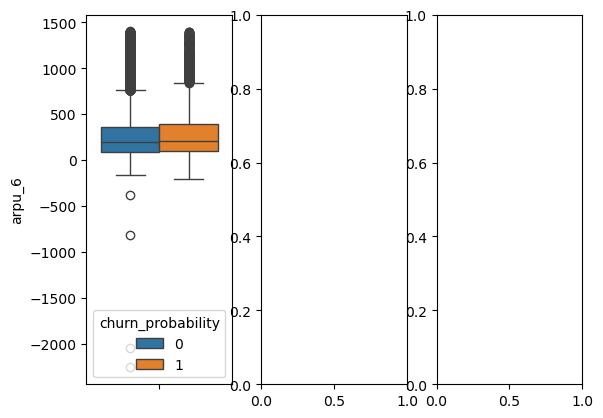

data = (69999, 159), data[condition] = (69299, 159)


In [564]:
data = inp3

def get_column_by_quantile(data, column_name, quantile):
    condition = data[column_name] < data[column_name].quantile(quantile)
    return data[condition]

fig, axes = plt.subplots(nrows=1, ncols=3)
sns.boxplot(data = get_column_by_quantile(data, 'arpu_6', 0.99), y='arpu_6', hue='churn_probability', ax=axes[0])
plt.show()

print(f'data = {data.shape}, data[condition] = {data[condition].shape}')

## 3.6 Data loss

In [528]:
print(f'initial shape = {inp0.shape}')
print(f'shape after cleaning = {inp3.shape}')
print(f'data loss after cleaning = {round (100*(inp0.shape[0]-inp3.shape[0])/inp0.shape[0])}%')

initial shape = (69999, 172)
shape after cleaning = (69999, 159)
data loss after cleaning = 0%


### 3.6.1 Observation
- we don't have any data loss

# Exploratory Data Analysis

# Feature engineering and Variable Transformation

# Modelling

# Conclusions